## Data Augmentation Plan Using KDE and k-Nearest Neighbors

To expand our dataset, we’ll use a two-step approach involving Kernel Density Estimation (KDE) for the input variables and \( k \)-Nearest Neighbors for estimating the target variable.

1. **Generate New Input Samples with KDE**:
   - For each input variable, we estimate its distribution using KDE, which allows us to capture the shape of each variable’s data. 
   - We then use these KDE models to generate new samples for each variable. By combining these new samples, we create synthetic rows that follow similar distributions to our original dataset.

2. **Estimate Target Values Using \( k \)-Nearest Neighbors**:
   - Since we haven’t assigned any distribution to our target variable, we will estimate its values based on the nearest neighbors from the original dataset.
   - For each new synthetic sample, we find the \( k \)-nearest samples from the original dataset, based on their input features.
   - The target value for each new sample is calculated as the average target value of its \( k \)-nearest neighbors.

This approach allows us to increase our dataset size while preserving the original data patterns, helping improve model training with more diverse examples. 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy
import json
import os

sns.set(style='darkgrid', palette='deep')

In [11]:
path_to_processed_data = "../data/pre-processed/cleaned/"
path_df = os.path.join(path_to_processed_data, "tennis_data_processed.csv")

In [12]:
df = pd.read_csv(path_df)

In [3]:
df.head()

,product_price,product_original_price,product_star_rating,product_num_ratings,product_minimum_offer_price,is_prime,climate_pledge_friendly,has_variations,coupon_discount,sales_volume
0,44.52,80.0,4.6,709,44.52,1.0,0.0,1.0,0.0,429
1,42.50,75.0,4.7,2028,42.50,1.0,0.0,1.0,0.0,117
2,38.50,70.0,4.5,502,38.50,1.0,0.0,1.0,0.0,185
3,30.69,50.0,4.5,40996,30.69,1.0,0.0,1.0,0.0,110
4,60.00,80.0,4.6,397,60.00,1.0,0.0,1.0,0.0,144


## Explore estimated distributions

In [13]:
import joblib

distributions = joblib.load("../data/distributions/distributions.pkl")

In [14]:
distributions

[{'random_variable': 'product_price',
  'kind': 'non-parametric',
  'scipy_pdf_obj': <scipy.stats._kde.gaussian_kde at 0x7f66ab3e9f50>},
 {'random_variable': 'product_original_price',
  'kind': 'non-parametric',
  'scipy_pdf_obj': <scipy.stats._kde.gaussian_kde at 0x7f66ab3e9090>},
 {'random_variable': 'product_star_rating',
  'kind': 'non-parametric',
  'scipy_pdf_obj': <scipy.stats._kde.gaussian_kde at 0x7f66aaa98e90>},
 {'random_variable': 'product_num_ratings',
  'kind': 'non-parametric',
  'scipy_pdf_obj': <scipy.stats._kde.gaussian_kde at 0x7f66aaa9b350>},
 {'random_variable': 'product_minimum_offer_price',
  'kind': 'non-parametric',
  'scipy_pdf_obj': <scipy.stats._kde.gaussian_kde at 0x7f66ab3bca10>},
 {'random_variable': 'is_prime',
  'kind': 'parametric',
  'scipy_pdf_obj': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7f66ac8d2010>},
 {'random_variable': 'climate_pledge_friendly',
  'kind': 'parametric',
  'scipy_pdf_obj': <scipy.stats._distn_infrastructure.rv_

# Generate input samples

In [15]:
pdf = distributions[5]["scipy_pdf_obj"]
pdf.rvs(size=100).reshape(1, -1)

array([[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [16]:
input_samples = []
aug_factor = 330.0  # Number of times the original dataset's size will be increased
n_samples = int(len(df) * aug_factor)

for distribution_obj in distributions:
    print(distribution_obj["random_variable"])
    pdf = distribution_obj["scipy_pdf_obj"]
    
    if distribution_obj["kind"] == "parametric":
        # Generate synthetic samples using rvs() for parametric distributions
        syntetic_samples = pdf.rvs(size=n_samples).reshape(n_samples,)
    elif distribution_obj["kind"] == "non-parametric":
        # Generate synthetic samples using resample() for non-parametric distributions
        syntetic_samples = pdf.resample(size=n_samples).reshape(n_samples,)
    
    # Append the generated samples to the input_samples list
    input_samples.append(syntetic_samples)

# Stack all generated samples into a single numpy array
input_samples = np.column_stack(input_samples)

# Check the final shape
print(input_samples.shape)


product_price
product_original_price
product_star_rating
product_num_ratings
product_minimum_offer_price
is_prime
climate_pledge_friendly
has_variations
coupon_discount
(406560, 9)


In [17]:
df_augmented = pd.DataFrame(data=input_samples, columns=df.columns.drop("sales_volume"))

In [18]:
df_augmented.head(20)

,product_price,product_original_price,product_star_rating,product_num_ratings,product_minimum_offer_price,is_prime,climate_pledge_friendly,has_variations,coupon_discount
0,35.872073,5.501414,5.094145,230.030832,18.535583,0.0,0.0,0.0,-0.128998
1,45.268517,-1.267976,4.758036,467.819080,122.590399,0.0,0.0,0.0,0.711127
2,38.098744,-0.069412,4.667847,684.428862,18.199048,0.0,0.0,0.0,0.147294
3,-11.156650,2.071408,3.962769,935.861856,29.458956,1.0,0.0,0.0,0.328163
4,23.960028,-3.239160,0.333552,-101.182823,77.330142,0.0,0.0,0.0,-0.817386
5,-0.513134,1.925461,0.118578,660.388705,84.188335,0.0,0.0,0.0,-0.382020
6,23.271272,1.386795,3.948622,580.779139,-20.280165,0.0,0.0,0.0,-0.675854
7,6.842633,-1.321089,4.561452,1064.333517,32.521287,0.0,0.0,0.0,-0.881416
8,58.827702,-2.849758,5.381545,7996.428570,7.860104,0.0,0.0,0.0,-0.879572
9,39.243356,-0.748299,-0.741583,1604.139408,23.276522,1.0,0.0,1.0,0.519942


In [19]:
from random import sample

In [20]:
synthetic_samples_temp = df_augmented.copy().sample(310)
synthetic_samples_temp["label"] = "sythetic"

df_temp = df.copy()
df_temp["label"] = "original"

df_comparison = pd.concat([synthetic_samples_temp, df_temp])

<Figure size 1500x1500 with 0 Axes>

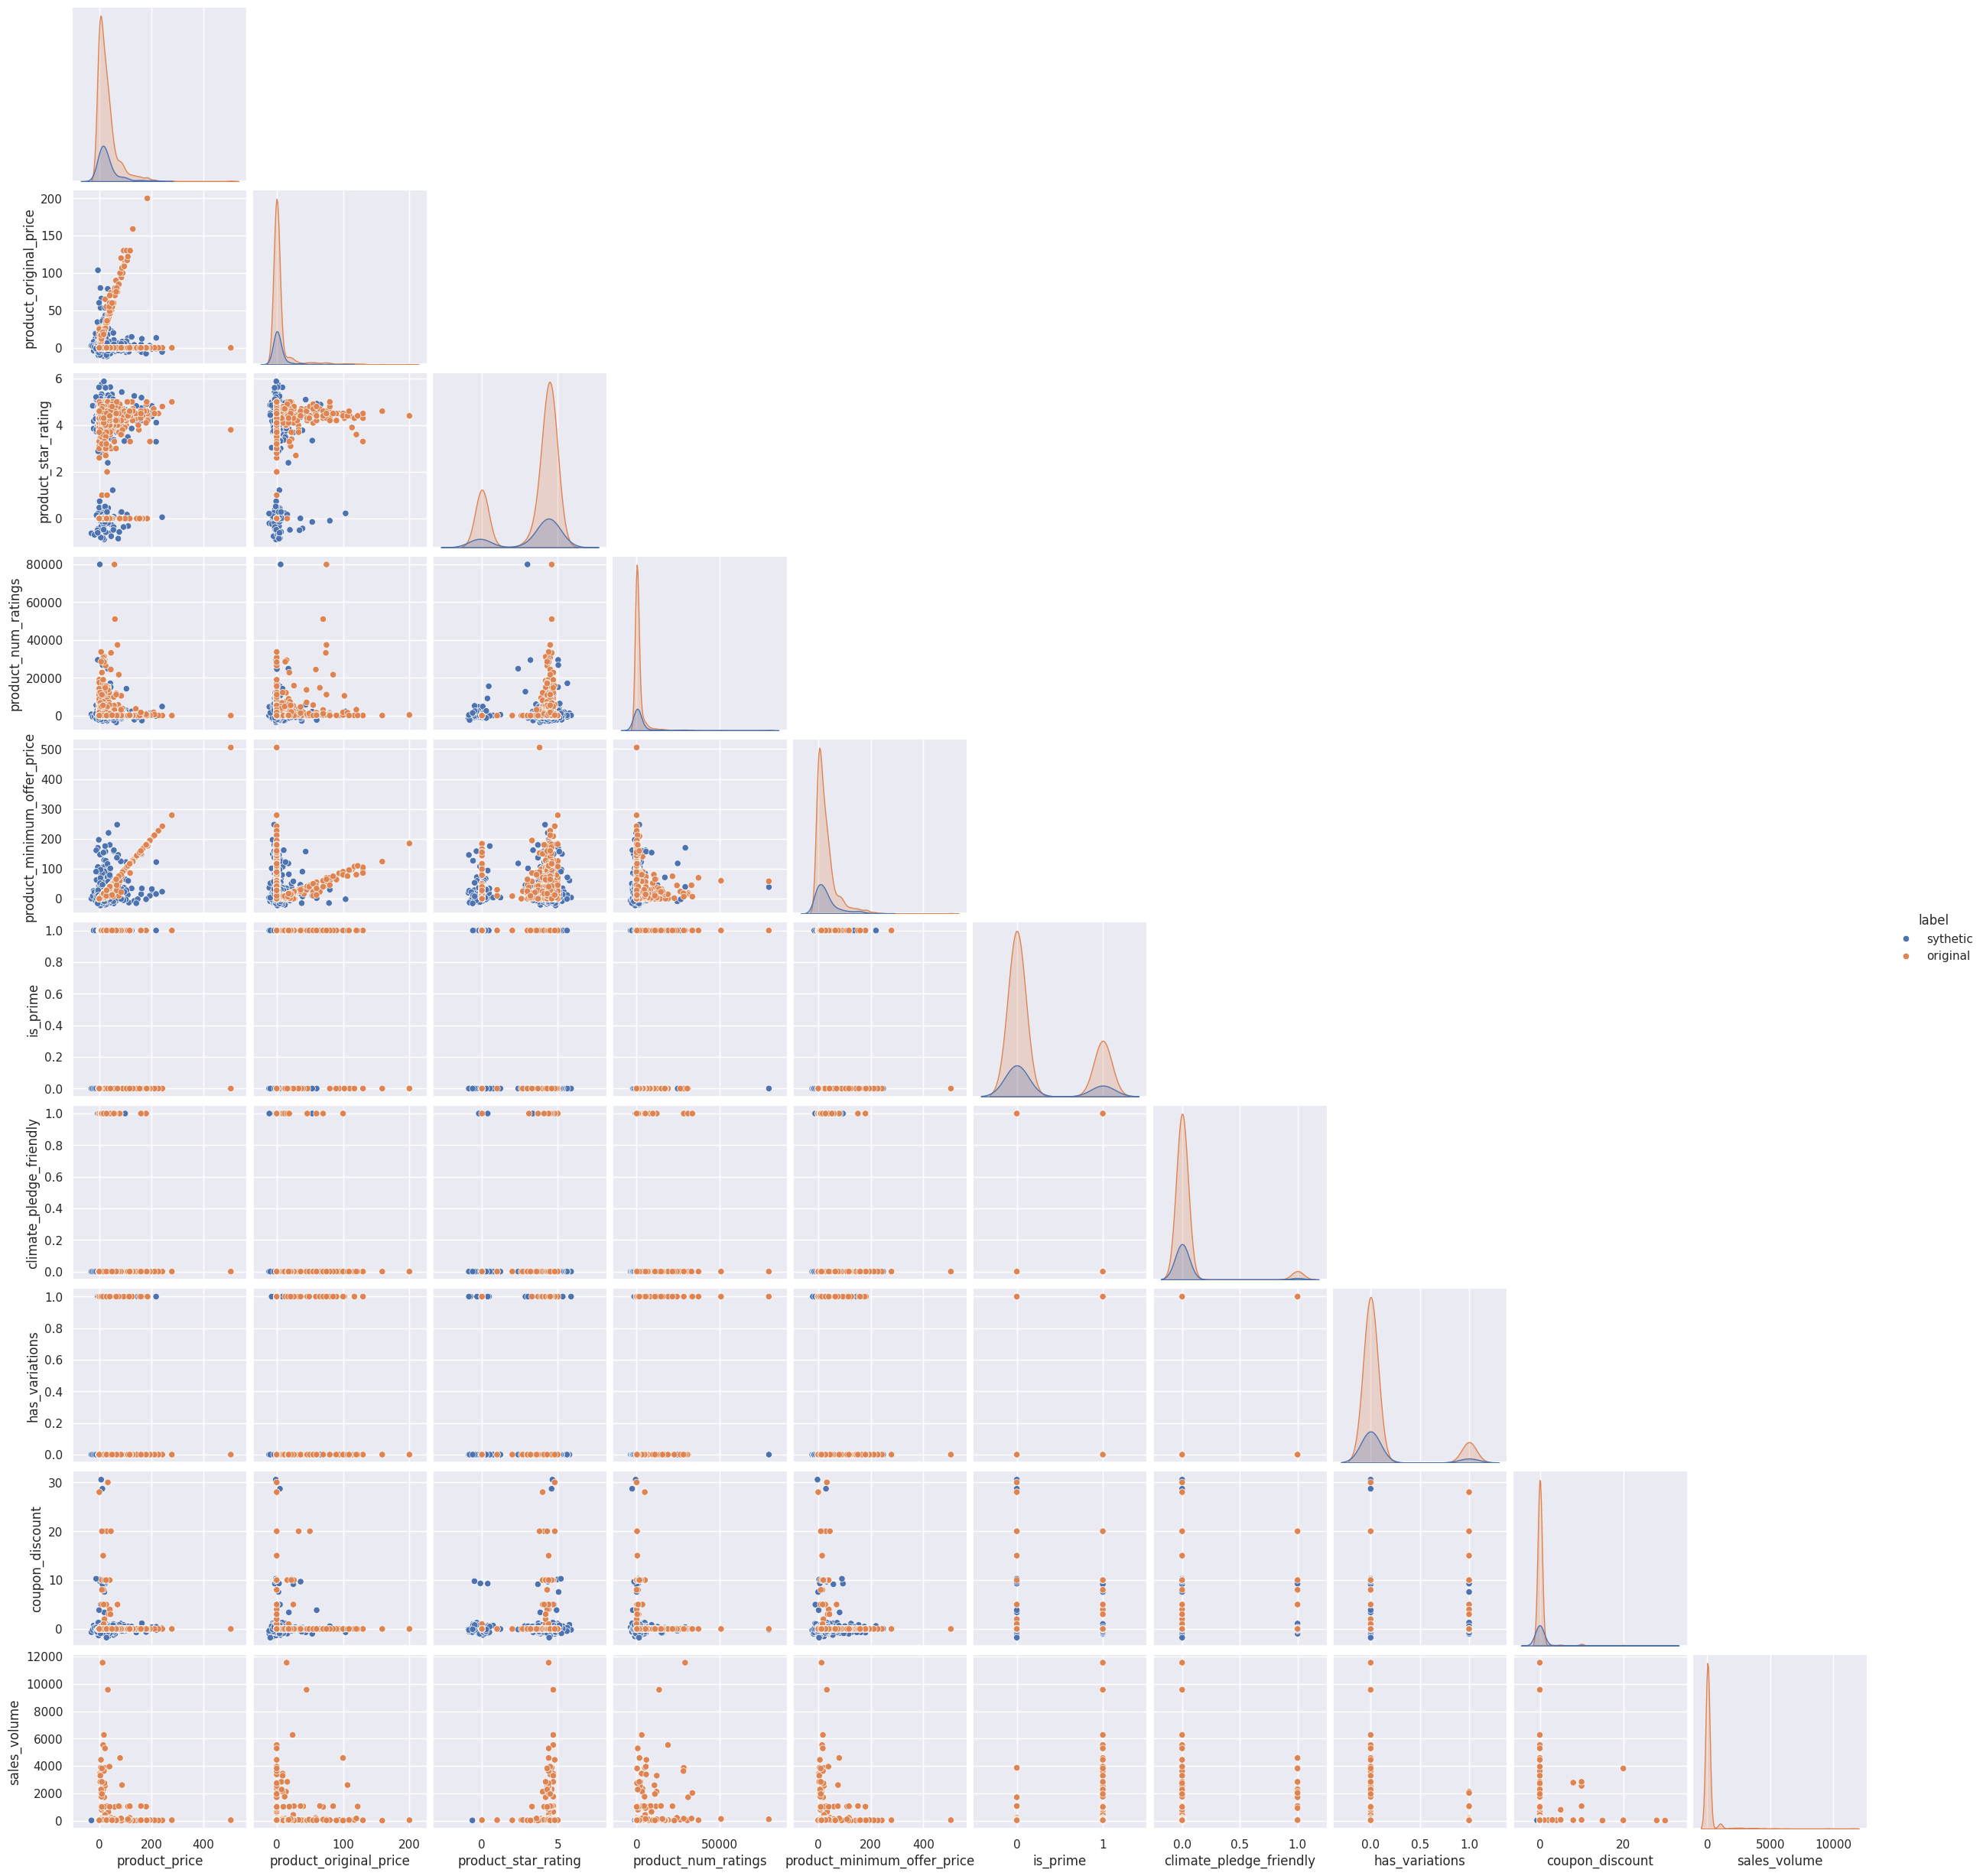

In [21]:
plt.figure(figsize=(15, 15))
plt.suptitle("Comparison: Original vs Sythetic samples", y=0.9)
sns.pairplot(data=df_comparison, corner=True, hue="label")

plt.show()

# Generate output samples

In [103]:
X = df.drop("sales_volume", axis=1).to_numpy()
x = df_augmented.values[0]

In [129]:
np.sort(np.linalg.norm(X-x, axis=1), axis=0)[:10][[0, 3, 4]]

array([21.02334699, 27.21018832, 34.02033434])

In [ ]:
np.linalg.norm(X-x)

156181.10114108614

In [140]:
k = 15

X = df.drop("sales_volume", axis=1).to_numpy()
y = df["sales_volume"].to_numpy()
y_hat_array = []
for x in df_augmented.values:
    euclidean_distances = np.linalg.norm(X-x, axis=1)
    sorted_indices = np.argsort(euclidean_distances, axis=0)[:k]
    y_knn = y[sorted_indices]
    y_hat = y_knn.mean()
    y_hat_array.append(int(y_hat))

y_hat_array = np.array([y_hat_array]).reshape(len(df_augmented),)

In [141]:
y_hat_array.shape

(102300,)

In [142]:
df_augmented["sales_volume"] = y_hat_array

In [143]:
df_augmented

,product_price,product_original_price,product_star_rating,product_num_ratings,product_minimum_offer_price,is_prime,climate_pledge_friendly,has_variations,coupon_discount,sales_volume
0,36.661780,63.161923,4.078384,359.557636,59.911637,1.0,0.0,1.0,-0.099590,47
1,46.874729,67.600951,4.313783,-814.577238,41.928306,1.0,0.0,1.0,0.404374,33
2,24.425356,52.276780,4.546788,-953.988191,24.472614,1.0,0.0,1.0,0.077852,33
3,71.123465,79.246256,4.649976,3696.268226,44.480069,1.0,0.0,1.0,7.497777,153
4,45.094955,87.757177,3.900340,-760.120956,43.209550,1.0,0.0,1.0,0.387575,34
...,...,...,...,...,...,...,...,...,...,...
102295,46.779757,58.928183,4.581862,8210.441696,58.331875,0.0,0.0,1.0,0.120091,140
102296,37.897578,82.486029,4.353838,7109.313648,136.845703,0.0,0.0,1.0,-0.150161,112
102297,82.936836,43.497572,4.422944,6050.614619,41.857397,1.0,0.0,1.0,0.354577,372
102298,59.421346,52.074959,4.097998,1277.781819,106.742618,1.0,0.0,1.0,-0.082793,108


<Figure size 1500x1500 with 0 Axes>

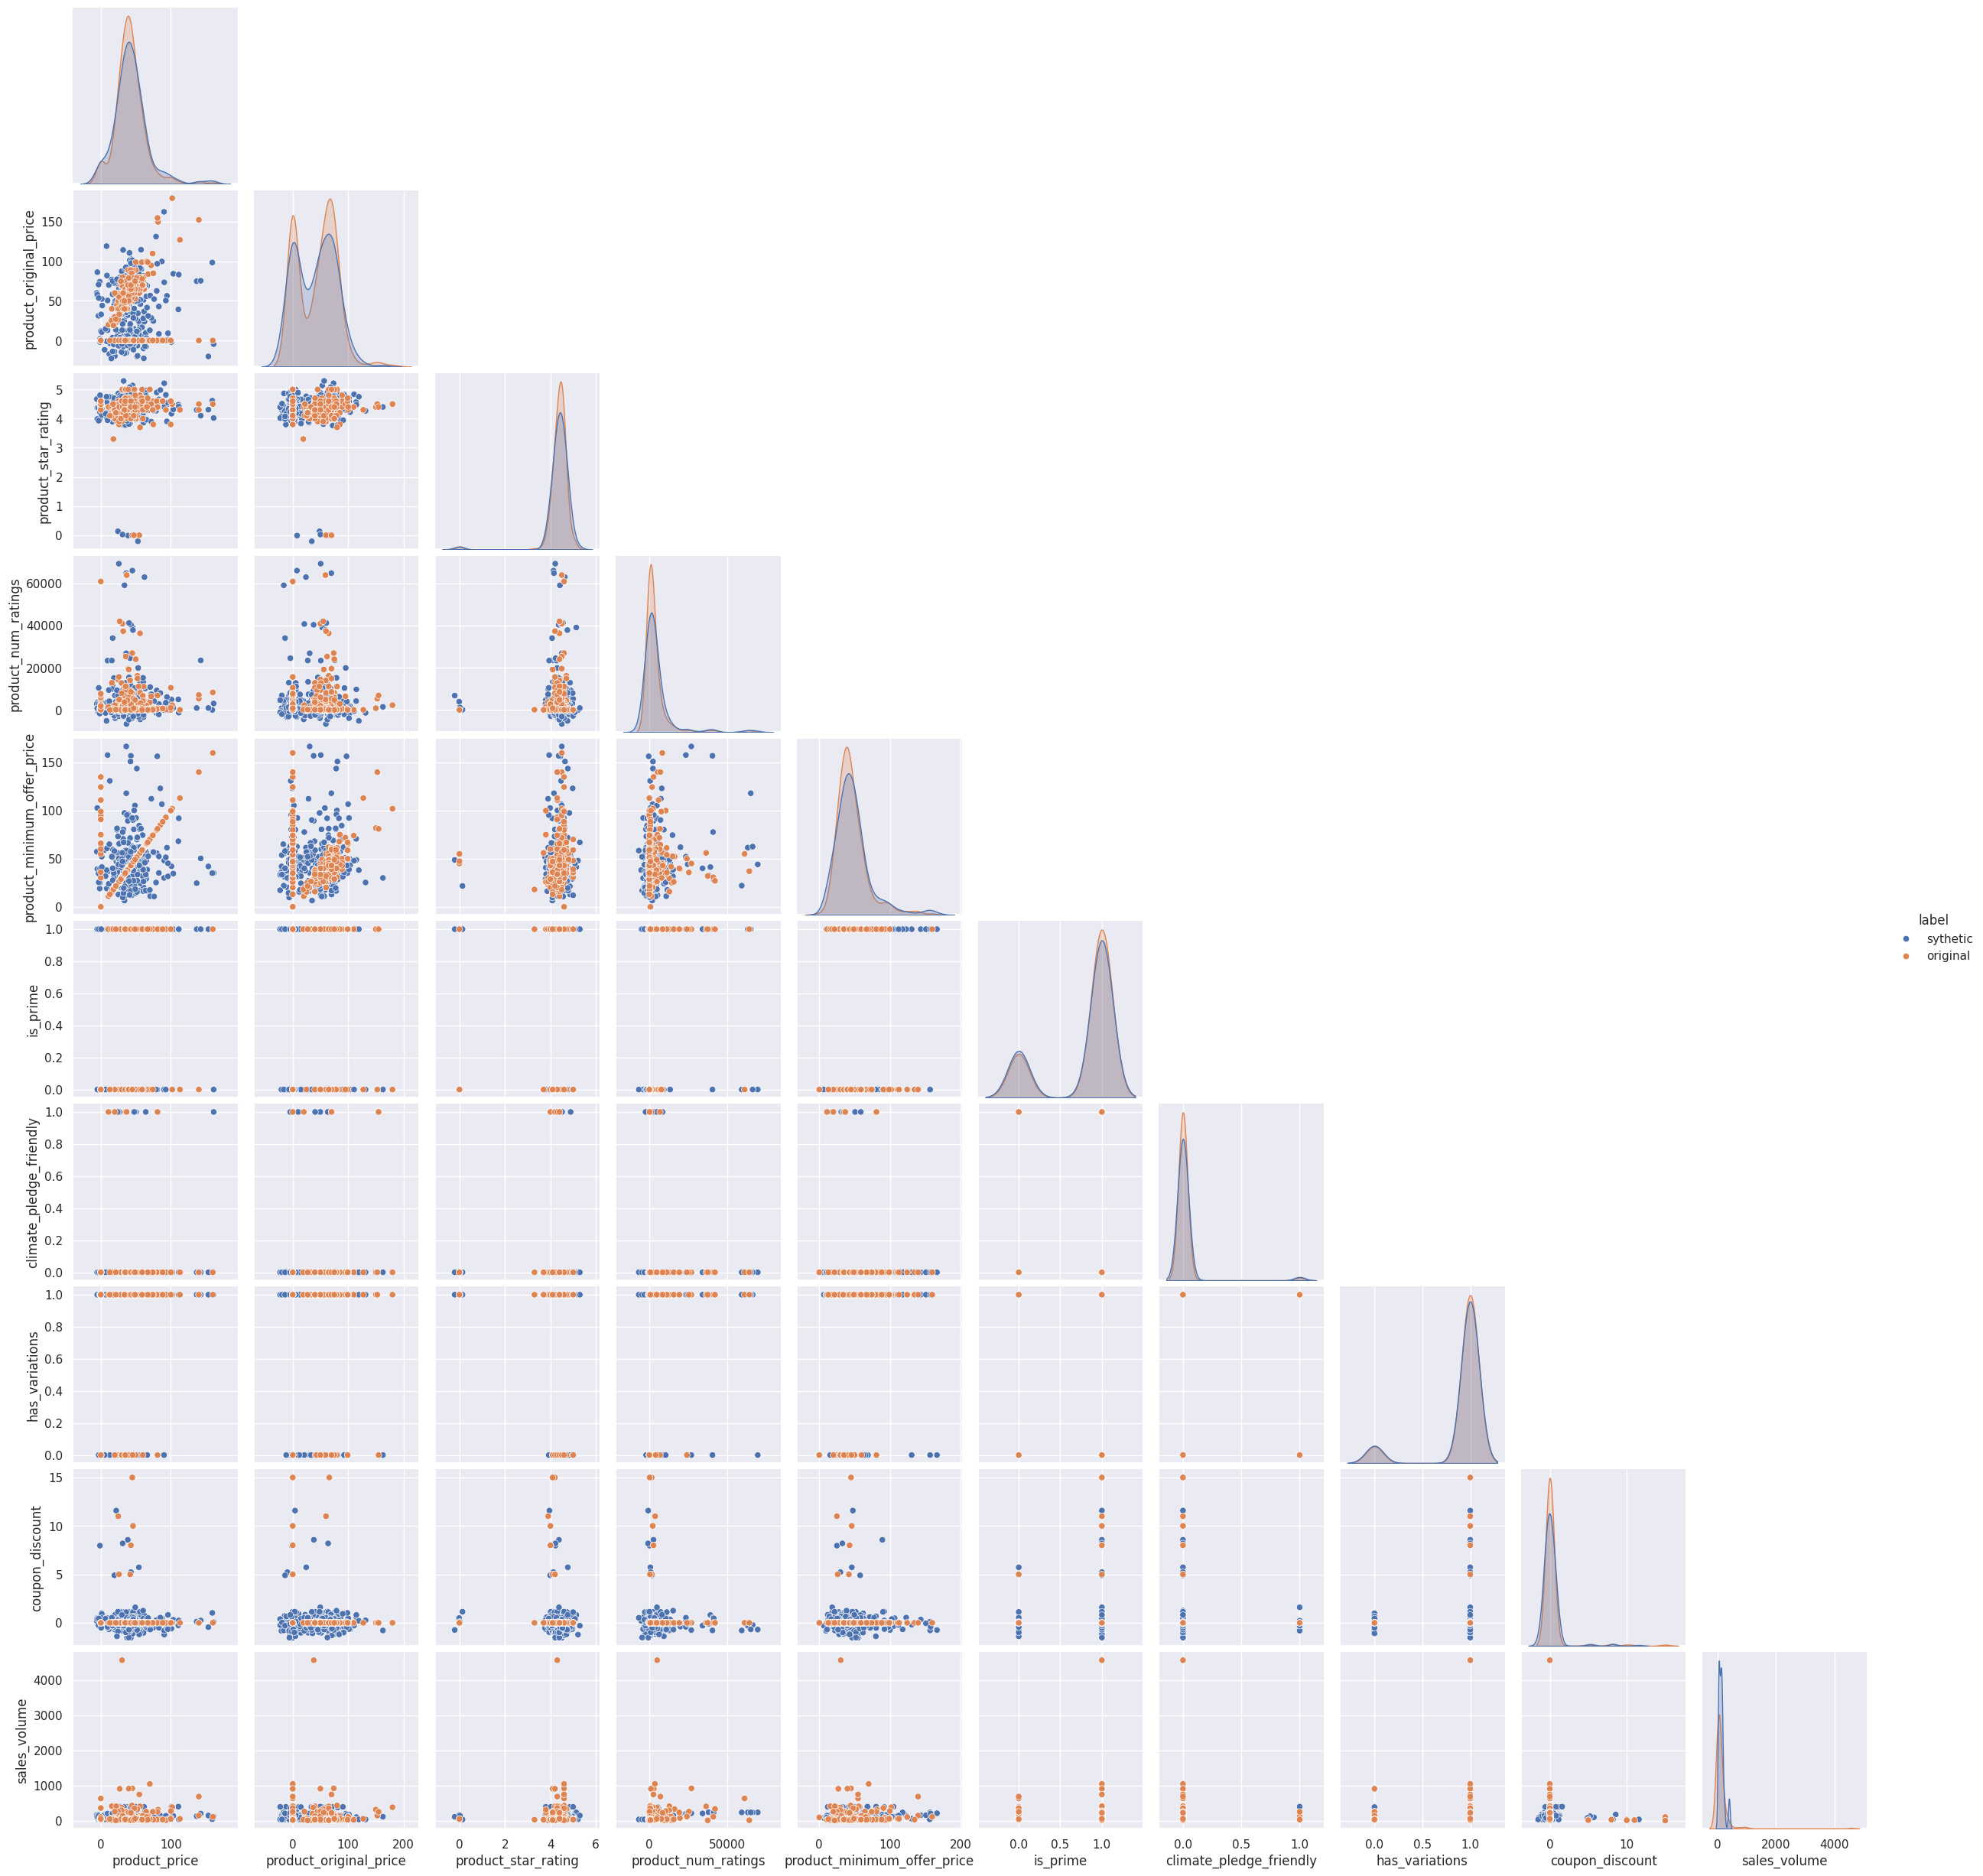

In [144]:
synthetic_samples_temp = df_augmented.copy().sample(310)
synthetic_samples_temp["label"] = "sythetic"

df_temp = df.copy()
df_temp["label"] = "original"

df_comparison = pd.concat([synthetic_samples_temp, df_temp])
plt.figure(figsize=(15, 15))
plt.suptitle("Comparison: Original vs Sythetic samples", y=0.9)
sns.pairplot(data=df_comparison, corner=True, hue="label")

plt.show()

# Save results

In [145]:
df_augmented.to_csv("../data/processed/tennis_augmented.csv", index=False)